# Trabajo práctico - Aprendizaje Automático I

Vamos a trabajar con el dataset `weatherAUS.csv` que contiene información sobre el clima de Australia en los últimos diez años. El objetivo es usar la información del dataset para predecir los atributos `RainTomorrow` y `RainfallTomorrow` con nuevos datos. Para esto vamos a utilizar modelos de regresión lineal, regresión logística y redes neuronales.

# Análisis exploratorio y limpieza de datos

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

In [2]:
df_original = pd.read_csv('datasets/weatherAUS.csv', index_col=0)

# Columnas

* **Sunshine:** Numero de horas de sol en el dia
* **Rainfall:** Cantidad de lluvia en el dia en mm
* **Evaporation:** La denominada evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
* **WindGustDir:** La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche
* **WindGustSpeed:** La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas previas a la medianoche
* **WindDir9am:** Dirección del viento a las 9 a.m.
* **WindDir3pm:** direccion del viento alas 3pm
* **WindSpeed9am:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 9 a.m.
* **WindSpeed3pm:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 3 p.m.
* **Humidity9am:** Humedad (porcentaje) a las 09:00 horas.
* **Humidity3pm:** Humedad (porcentaje) a las 15:00 horas.
* **Pressure9am:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 9 a.m.
* **Pressure3pm:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 3 p.m.
* **Cloud9am:** Fracción del cielo oscurecida por las nubes a las 9:00 horas. Esto se mide en "oktas", que son una unidad de octavos. Registra cuántas octavas partes del cielo están oscurecidas por las nubes. Una medida 0 indica cielo completamente despejado mientras que un 8 indica que está completamente nublado.
* **Cloud3pm:**
* **Temp9am:** Temperatura (grados C) a las 9 a.m.
* **Temp3pm:**
* **RainToday:** Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
* **RainTomorrow:** La cantidad de lluvia del día siguiente en mm. Se utiliza para crear la variable de respuesta RainTomorrow. Una especie de medida del "riesgo".
* **RainfallTomorrow:** Variable booleana, indica si el día siguiente va a llover o no.

Para entrenar los modelos solamente vamos a usar cinco ciudades del dataset

In [4]:
ciudades = ['Sydney',
            'SydneyAirport',
            'Canberra',
            'Melbourne',
            'MelbourneAirport']

df = df_original[df_original['Location']\
                 .isin(ciudades)]\
                 .copy()\
                 .reset_index(drop=True)

Ordenamos el dataframe por localidad y fecha porque vamos a usar el metodo de la interpolacion lienal para llenar valores faltantes y tambien el metodo de valor mas cercano valido. 

In [5]:
df.sort_values(['Location', 'Date'], inplace=True)

Imputamos los datos que no son medidas estadicas antes de separar el dataset

## MinTemp y MaxTemp

Para estas variables decidimos usar una interpolación, ya que la temperatura de los días faltantes probablemente se encuentre en algún punto entre la temperatura del día anterior y la del día posterior.

In [6]:
df['MinTemp'].interpolate(method='linear', inplace=True)
df['MaxTemp'].interpolate(method='linear', inplace=True)

In [7]:
# fig, axs = plt.subplots(1, 5, figsize=(15, 4))  

# for i, ciudad in enumerate(ciudades):
#     df_ciudad = df[df['Location'] == ciudad]
#     df_ciudad['Year'] = pd.to_datetime(df_ciudad['Date']).dt.year 
    
#     df_grouped = df_ciudad.groupby('Year').mean().reset_index()
    
#     axs[i].plot(df_grouped['Year'], df_grouped['MinTemp'], label='MinTemp', marker='o')
#     axs[i].plot(df_grouped['Year'], df_grouped['MaxTemp'], label='MaxTemp', marker='o')
#     axs[i].set_title(f'{ciudad} (Agrupado por Año)')
#     axs[i].set_ylabel('Temperatura Promedio')
#     axs[i].grid(True)
#     axs[i].legend()

# plt.xlabel('Año')
# plt.tight_layout()
# plt.show()

## WindDir 

Para la direcciones viento elegimos llenarla con el valor siguiente válido ya que es dataset está ordenado por fecha.

In [8]:
df['WindDir9am'].fillna(method='ffill', inplace=True)
df['WindDir3pm'].fillna(method='ffill', inplace=True)

## RainToday y RainTomorrow

Los valores Nan de estas dos variables son muy pocos y difíciles de imputar por eso decidimos eliminarlos.

In [9]:
df.RainToday.isna().sum(), df.RainTomorrow.isna().sum()

(787, 787)

In [10]:
df.dropna(subset=['RainTomorrow'], inplace=True)
df.dropna(subset=['RainToday'], inplace=True)

# Split del dataset

Separamos el dataset para en entrenamiento y prueba

In [11]:
x_reg = df.drop(columns=['RainTomorrow', 'RainfallTomorrow'])
y_reg = df['RainfallTomorrow']

x_clas = x_reg
y_clas = df['RainTomorrow']

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.2, random_state=42)
x_train_clas, x_test_clas, y_train_clas, y_test_clas = train_test_split(x_clas, y_clas, test_size=0.2, random_state=42)

In [12]:
df_reg  = pd.concat([x_train_reg, y_train_reg], axis=1)
df_clas = pd.concat([x_train_clas, y_train_clas], axis=1)

# ¿Está balanceado el dataset?

### Dataset regresión

El dataset no está balanceado porque la variable independietne que queremos predecir tiene muchos valores iguales a $0$.

<Axes: >

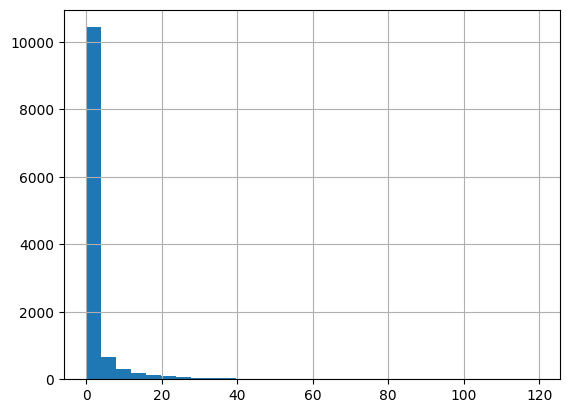

In [13]:
y_train_reg.hist(bins=30)

In [14]:
y_train_reg.shape

(12028,)

In [15]:
y_train_reg.value_counts()

RainfallTomorrow
0.0     7743
0.2      666
0.4      327
0.6      231
0.8      152
        ... 
41.8       1
54.4       1
40.6       1
57.8       1
53.0       1
Name: count, Length: 261, dtype: int64

In [16]:
f'{7784/12788:.2f}'

'0.61'

En el histograma vemos gráficamente que el dataset está desbalanceado, ya que la moda es $0$ y con los valores vemos que aproximadamente el $61\%$ de los valores de la variable a predecir son $0$.

### Dataset clasificación

<Axes: >

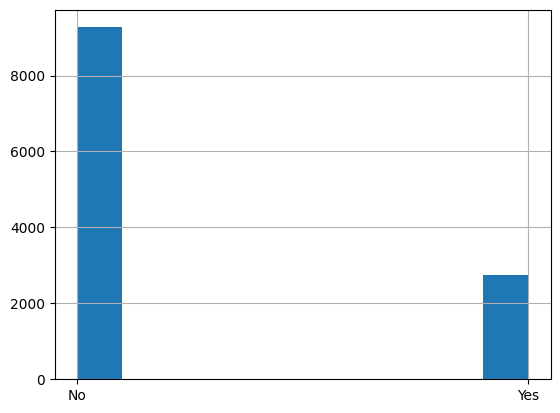

In [17]:
y_train_clas.hist()

In [18]:
y_train_clas.shape

(12028,)

In [19]:
y_train_clas.value_counts()

RainTomorrow
No     9270
Yes    2758
Name: count, dtype: int64

In [20]:
f'{9337/12788:.2f}'

'0.73'

Para el caso del dataset que usaremos para la clasificación también vemos que hay un importante desbalanceo, ya que el $73\%$ de sus valores pertenecen a una de las clases.

# Imputación de datos

## WindGustDir 

Esta variable en un momento habíamos decidido eliminarla (tenía un años con valores `nan`) pero ahora creemos que es mejor llenarla con la moda en función a la localidad y estación del año. 

In [13]:
df_reg['Date']  = pd.to_datetime(df_reg['Date'])
df_reg['Month'] = df_reg['Date'].dt.month

df_clas['Date']  = pd.to_datetime(df_clas['Date'])
df_clas['Month'] = df_clas['Date'].dt.month

Estaciones en Australia
- Otoño: del 1 de marzo al 31 de mayo
- Invierno: del 1 de junio al 31 de agosto
- Primavera: del 1 de septiembre al 30 de noviembre
- Verano: del 1 de diciembre al 28 (ó 29) de febrero

In [14]:
estaciones_dict = {1:  'Verano',
                   2:  'Verano',
                   3:  'Otoño',
                   4:  'Otoño',
                   5:  'Otoño',
                   6:  'Invierno',
                   7:  'Invierno',
                   8:  'Invierno',
                   9:  'Primavera',
                   10: 'Primavera',
                   11: 'Primavera',
                   12: 'Verano'}

df_reg['Estacion']  = df_reg['Month'].map(estaciones_dict)
df_clas['Estacion'] = df_reg['Month'].map(estaciones_dict)

In [15]:
def temporada_ubicacion(df, columna_a_rellenar, columna_ubicacion, columna_temporada):
    
    moda_por_ubicacion_temporada = df.groupby([columna_ubicacion, columna_temporada])[columna_a_rellenar]\
                                     .apply(lambda x: x.mode().iloc[0])

    df[columna_a_rellenar] = df.apply(
        lambda fila: moda_por_ubicacion_temporada[fila[columna_ubicacion],
                                                  fila[columna_temporada]] 
                                                if pd.isna(fila[columna_a_rellenar]) 
                                                else fila[columna_a_rellenar],
        axis=1)

    return df

In [16]:
df_reg  = temporada_ubicacion(df_reg,  'WindGustDir', 'Location', 'Estacion')
df_clas = temporada_ubicacion(df_clas, 'WindGustDir', 'Location', 'Estacion')

Notamos que hay una gran cantidad de direcciones cardinales en el dataframe.

In [17]:
df_reg['WindGustDir'].unique()

array(['S', 'SSW', 'NE', 'ENE', 'N', 'W', 'NW', 'WNW', 'SE', 'E', 'SW',
       'NNW', 'NNE', 'WSW', 'SSE', 'ESE'], dtype=object)

Esto puede resultar poco práctico para entrenar los modelos, por lo que decidimos quedarnos solamenente con las cuatros dirreciones principales: N, S, E, W.

In [59]:
df_reg['WindGustDir']  = df_reg['WindGustDir'].str[0]
df_reg['WindDir9am']   = df_reg['WindDir9am'].str[0]
df_reg['WindDir3pm']   = df_reg['WindDir3pm'].str[0]

df_clas['WindGustDir']  = df_clas['WindGustDir'].str[0]
df_clas['WindDir9am']   = df_clas['WindDir9am'].str[0]
df_clas['WindDir3pm']   = df_clas['WindDir3pm'].str[0]


In [ ]:
df_reg['WindDir9am']

## Rainfall

Para completar la variable `Rainfall` vamos a usar la moda de la distribución que es `0.0`, eso lo podemos comprobar con el siguiente histograma y loop.

Text(0.5, 1.0, 'Dataset Clasificación')

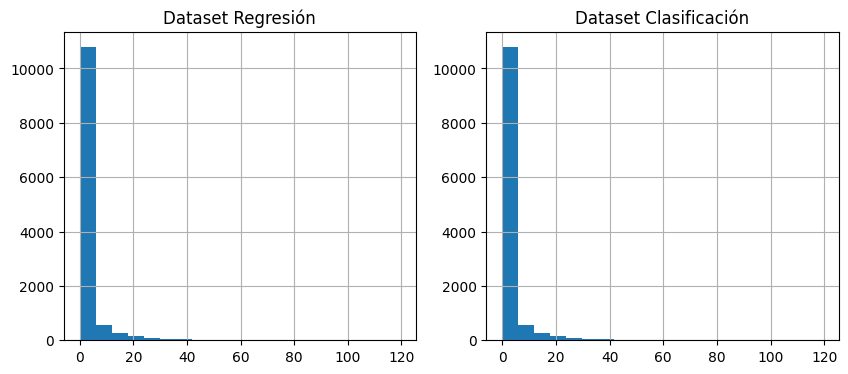

In [19]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Rainfall'].hist(bins=20)
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Rainfall'].hist(bins=20)
plt.title('Dataset Clasificación')

In [20]:
for ciudad in ciudades:
    rain = \
        df_reg[df_reg['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [21]:
for ciudad in ciudades:
    rain = \
        df_clas[df_clas['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [22]:
df_reg['Rainfall'].fillna(0.0, inplace=True)
df_clas['Rainfall'].fillna(0.0, inplace=True)

## Evaporation

En esta variable vemos que la distribución es bastante simétrica, además la media y la mediana tiene valores muy cercanos, en esta caso no hay sesgo, por lo tanto decidimos completar los valores faltante con la media.

Text(0.5, 1.0, 'Dataset Clasificación')

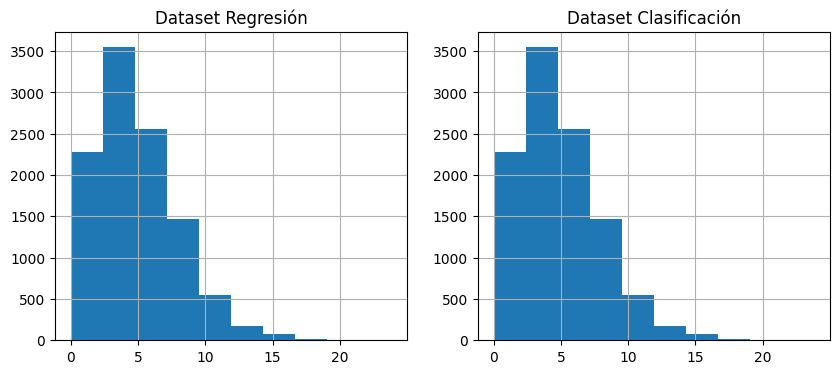

In [23]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Evaporation'].hist()
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Evaporation'].hist()
plt.title('Dataset Clasificación')

In [24]:
df_reg['Evaporation'].mean(), df_reg['Evaporation'].median()

(4.873762051858092, 4.2)

In [25]:
df_clas['Evaporation'].mean(), df_clas['Evaporation'].median()

(4.873762051858092, 4.2)

In [26]:
df_reg['Evaporation'].fillna(df_reg['Evaporation'].mean(), inplace=True)
df_clas['Evaporation'].fillna(df_clas['Evaporation'].mean(), inplace=True)

## Sunshine

En este histograma vemos que la distribución es bimodal, por lo que para imputar los valores faltantes vamos usar la mediana, ya que la media está sesgada por la gran cantidad de `0.0`

Text(0.5, 1.0, 'Dataset Clasificación')

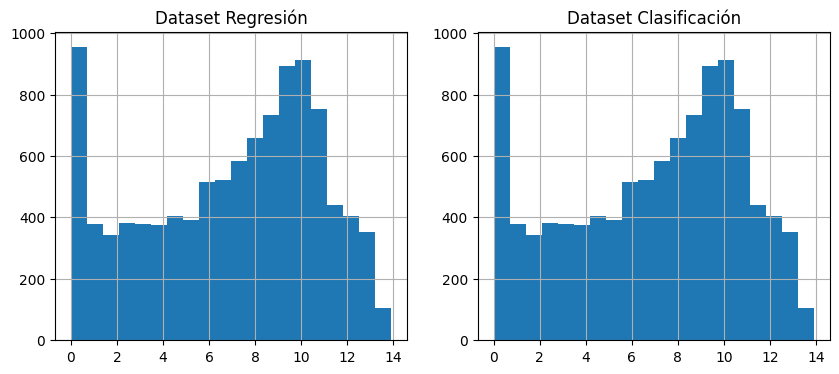

In [27]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Sunshine'].hist(bins=20)
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Sunshine'].hist(bins=20)
plt.title('Dataset Clasificación')

In [28]:
df_reg['Sunshine'].fillna(df_reg['Sunshine'].median(), inplace=True)
df_clas['Sunshine'].fillna(df_clas['Sunshine'].median(), inplace=True)

## WindSpeed

En este caso observando los histogramas vemos que podemos completar los valores faltantes con la media.

Text(0.5, 1.0, 'Clasificación - WindSpeed3pm')

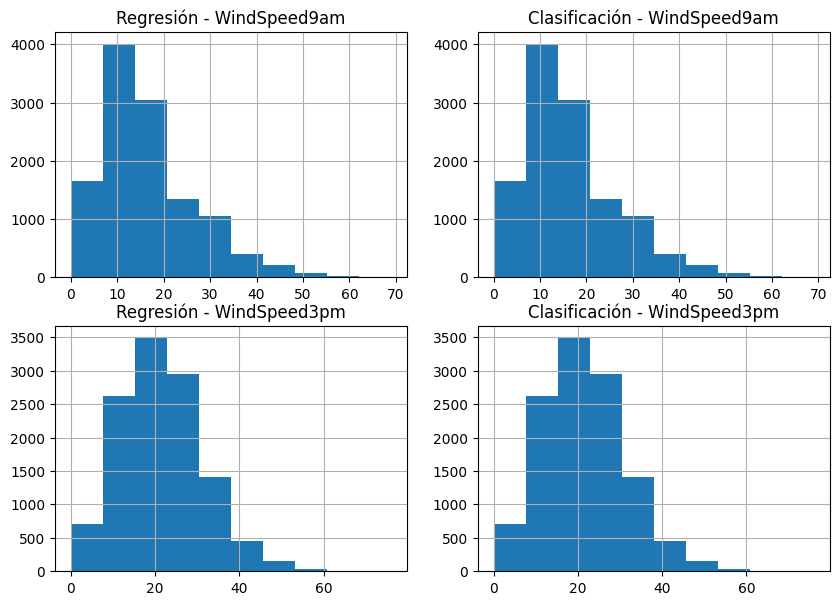

In [29]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['WindSpeed9am'].hist()
plt.title('Regresión - WindSpeed9am')
plt.subplot(222)
df_clas['WindSpeed9am'].hist()
plt.title('Clasificación - WindSpeed9am')
plt.subplot(223)
df_reg['WindSpeed3pm'].hist()
plt.title('Regresión - WindSpeed3pm')
plt.subplot(224)
df_clas['WindSpeed3pm'].hist()
plt.title('Clasificación - WindSpeed3pm')

In [30]:
df_reg['WindSpeed9am'].fillna(df_reg['WindSpeed9am'].mean(),inplace=True)
df_clas['WindSpeed9am'].fillna(df_clas['WindSpeed9am'].mean(),inplace=True)

df_reg['WindSpeed3pm'].fillna(df_reg['WindSpeed3pm'].mean(),inplace=True)
df_clas['WindSpeed3pm'].fillna(df_clas['WindSpeed3pm'].mean(),inplace=True)

## WindSGustSpeed

Vemos que la media y la media son similares esto nos dice que la distribucion es simetrica por lo cual lo llenamos con la mediana

In [31]:
df.WindGustSpeed.describe()

count    13602.000000
mean        44.290619
std         14.948251
min         11.000000
25%         33.000000
50%         43.000000
75%         54.000000
max        122.000000
Name: WindGustSpeed, dtype: float64

In [32]:
df_reg['WindGustSpeed'].fillna(df_reg['WindGustSpeed'].median(), inplace=True)
df_clas['WindGustSpeed'].fillna(df_clas['WindGustSpeed'].median(), inplace=True)

## Humidity

Los valores `nan` de las variables humedad los completamos con la media 

In [33]:
df_reg['Humidity9am'].describe()

count    11961.000000
mean        68.862553
std         15.649308
min         11.000000
25%         59.000000
50%         70.000000
75%         80.000000
max        100.000000
Name: Humidity9am, dtype: float64

Text(0.5, 1.0, 'Clasificación - Humidity3pm')

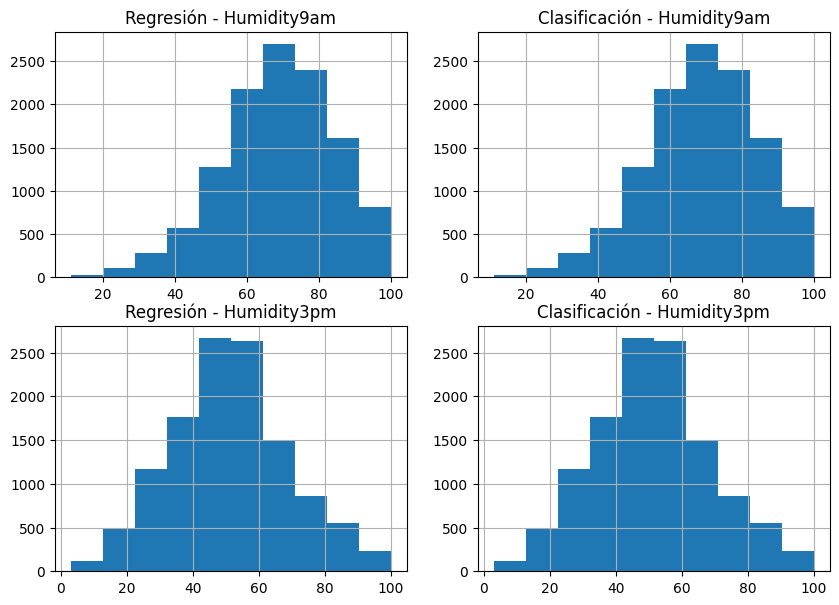

In [34]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Humidity9am'].hist()
plt.title('Regresión - Humidity9am')
plt.subplot(222)
df_clas['Humidity9am'].hist()
plt.title('Clasificación - Humidity9am')
plt.subplot(223)
df_reg['Humidity3pm'].hist()
plt.title('Regresión - Humidity3pm')
plt.subplot(224)
df_clas['Humidity3pm'].hist()
plt.title('Clasificación - Humidity3pm')

In [35]:
df_reg['Humidity9am'].fillna(df_reg['Humidity9am'].mean(),inplace=True)
df_clas['Humidity9am'].fillna(df_reg['Humidity9am'].mean(),inplace=True)

In [36]:
df_clas.Humidity3pm.describe()

count    11988.000000
mean        51.199867
std         17.772806
min          3.000000
25%         39.000000
50%         51.000000
75%         62.000000
max        100.000000
Name: Humidity3pm, dtype: float64

In [37]:
df_clas['Humidity3pm'].fillna(df_clas['Humidity3pm'].mean(), inplace=True)
df_reg['Humidity3pm'].fillna(df_reg['Humidity3pm'].mean(), inplace=True)

## Pressure

Los valores `nan` de esta variables los vamos a llenar con la media. 

Text(0.5, 1.0, 'Clasificación - Pressure3pm')

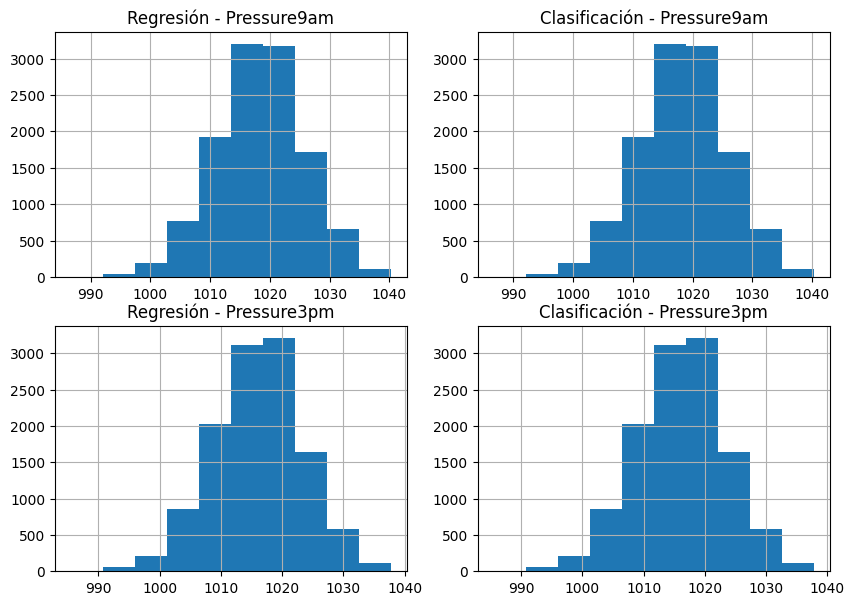

In [38]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Pressure9am'].hist()
plt.title('Regresión - Pressure9am')
plt.subplot(222)
df_clas['Pressure9am'].hist()
plt.title('Clasificación - Pressure9am')
plt.subplot(223)
df_reg['Pressure3pm'].hist()
plt.title('Regresión - Pressure3pm')
plt.subplot(224)
df_clas['Pressure3pm'].hist()
plt.title('Clasificación - Pressure3pm')

In [39]:
df_clas['Pressure3pm'].describe()

count    11823.000000
mean      1016.055453
std          7.277343
min        985.500000
25%       1011.200000
50%       1016.300000
75%       1021.000000
max       1037.800000
Name: Pressure3pm, dtype: float64

In [40]:
df_clas['Pressure9am'].describe()

count    11815.000000
mean      1018.325713
std          7.398393
min        986.700000
25%       1013.500000
50%       1018.500000
75%       1023.300000
max       1040.300000
Name: Pressure9am, dtype: float64

In [41]:
df_reg['Pressure9am'].describe()

count    11815.000000
mean      1018.325713
std          7.398393
min        986.700000
25%       1013.500000
50%       1018.500000
75%       1023.300000
max       1040.300000
Name: Pressure9am, dtype: float64

In [42]:
df_reg['Pressure9am'].fillna(df_reg['Pressure9am'].mean(), inplace=True)
df_reg['Pressure3pm'].fillna(df_reg['Pressure3pm'].mean(), inplace=True)

df_clas['Pressure9am'].fillna(df_clas['Pressure9am'].mean(), inplace=True)
df_clas['Pressure3pm'].fillna(df_clas['Pressure3pm'].mean(), inplace=True)

## Cloud 

Los valores `nan` de esta variable los vamos a llenar con la mediana, ya que en este caso la mediana es mas robusta que el promedio por la distribucion del la variable.

Text(0.5, 1.0, 'Clasificación - Cloud3pm')

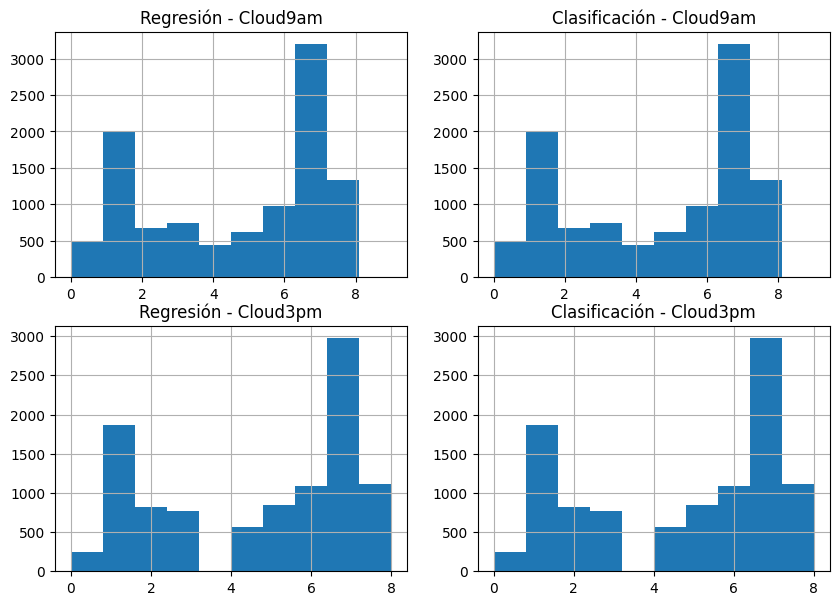

In [43]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Cloud9am'].hist()
plt.title('Regresión - Cloud9am')
plt.subplot(222)
df_clas['Cloud9am'].hist()
plt.title('Clasificación - Cloud9am')
plt.subplot(223)
df_reg['Cloud3pm'].hist()
plt.title('Regresión - Cloud3pm')
plt.subplot(224)
df_clas['Cloud3pm'].hist()
plt.title('Clasificación - Cloud3pm')

In [44]:
df_clas['Cloud3pm'].describe()

count    10287.000000
mean         4.718382
std          2.594606
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          8.000000
Name: Cloud3pm, dtype: float64

In [45]:
df_clas['Cloud9am'].describe()

count    10482.000000
mean         4.721618
std          2.734851
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          9.000000
Name: Cloud9am, dtype: float64

In [46]:
df_clas['Cloud3pm'].fillna(df_clas['Cloud3pm'].median(), inplace=True)
df_clas['Cloud9am'].fillna(df_clas['Cloud9am'].median(), inplace=True)

df_reg['Cloud3pm'].fillna(df_reg['Cloud3pm'].median(), inplace=True)
df_reg['Cloud9am'].fillna(df_reg['Cloud9am'].median(), inplace=True)

## Temp 

Las variables de temperatura de la mañana y tarde seran completadas con el promedio, ya que la distribucion es asimetrica, ademas la media y la media se encuentran muy proximas

Text(0.5, 1.0, 'Clasificación - Temp3pm')

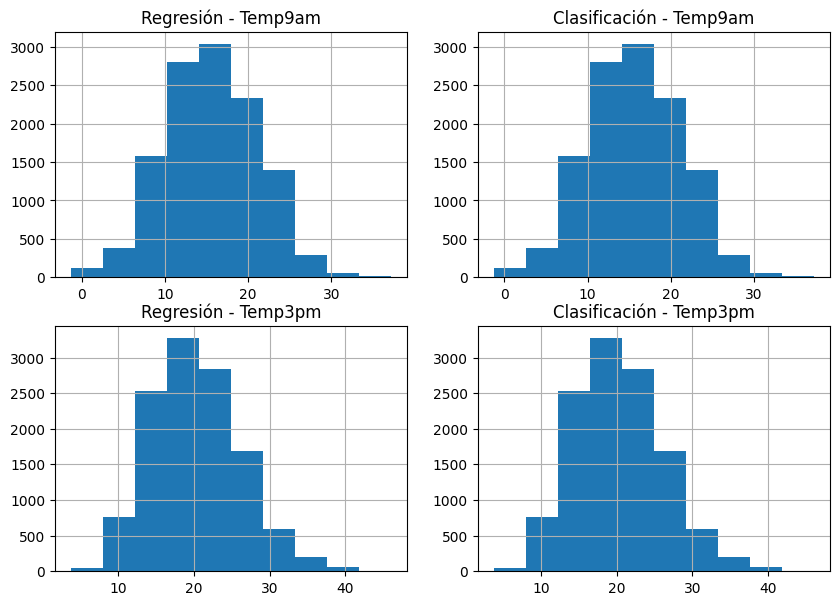

In [47]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Temp9am'].hist()
plt.title('Regresión - Temp9am')
plt.subplot(222)
df_clas['Temp9am'].hist()
plt.title('Clasificación - Temp9am')
plt.subplot(223)
df_reg['Temp3pm'].hist()
plt.title('Regresión - Temp3pm')
plt.subplot(224)
df_clas['Temp3pm'].hist()
plt.title('Clasificación - Temp3pm')

In [48]:
df_reg['Temp3pm'].mean(), df_reg['Temp3pm'].median() 

(20.28962876643915, 19.9)

In [49]:
df_reg['Temp9am'].mean(), df_reg['Temp9am'].median() 

(15.590394539703679, 15.4)

In [50]:
df_reg['Temp9am'].fillna(df_reg['Temp9am'].mean(), inplace=True)
df_reg['Temp3pm'].fillna(df_reg['Temp3pm'].mean(), inplace=True)

df_clas['Temp9am'].fillna(df_clas['Temp9am'].mean(), inplace=True)
df_clas['Temp3pm'].fillna(df_clas['Temp3pm'].mean(), inplace=True)

In [51]:
df_reg.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainfallTomorrow    0
Month               0
Estacion            0
dtype: int64

In [52]:
df_clas.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Month            0
Estacion         0
dtype: int64

# Codificación de variables categóricas

In [53]:
df_clas['RainToday'] = df_clas['RainToday'].replace({'Yes': 1, 'No': 0})
df_reg['RainToday']  = df_reg['RainToday'].replace({'Yes': 1, 'No': 0})

La variable `RainTomorrow` solo la usamos en el dataset de clasificación, es otro cambio que relizamos porque en los notebook anteriores la habíamos usado en el modelo de regresión lineal y esto nos estaría provocando una fuga de datos.

In [54]:
df_clas['RainTomorrow'] = df_clas['RainTomorrow'].replace({'Yes': 1, 'No': 0})

Eliminamos columnas que no vamos a usar

In [61]:
categoricas = ['Location', 'Month', 'Estacion', 'Date']

df_clasi = df_clas.drop(columns=categoricas).copy()
df_regre = df_reg.drop(columns=categoricas).copy()

In [65]:
df_regre = pd.get_dummies(df_regre)
df_clas  = pd.get_dummies(df_clas)

In [69]:
df_regre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12028 entries, 10395 to 11358
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           12028 non-null  float64
 1   MaxTemp           12028 non-null  float64
 2   Rainfall          12028 non-null  float64
 3   Evaporation       12028 non-null  float64
 4   Sunshine          12028 non-null  float64
 5   WindGustSpeed     12028 non-null  float64
 6   WindSpeed9am      12028 non-null  float64
 7   WindSpeed3pm      12028 non-null  float64
 8   Humidity9am       12028 non-null  float64
 9   Humidity3pm       12028 non-null  float64
 10  Pressure9am       12028 non-null  float64
 11  Pressure3pm       12028 non-null  float64
 12  Cloud9am          12028 non-null  float64
 13  Cloud3pm          12028 non-null  float64
 14  Temp9am           12028 non-null  float64
 15  Temp3pm           12028 non-null  float64
 16  RainToday         12028 non-null  int64  

# NORMALIZACION DE LAS VARIABLES CUANTITATIVAS 

In [64]:
df_regre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12028 entries, 10395 to 11358
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           12028 non-null  float64
 1   MaxTemp           12028 non-null  float64
 2   Rainfall          12028 non-null  float64
 3   Evaporation       12028 non-null  float64
 4   Sunshine          12028 non-null  float64
 5   WindGustSpeed     12028 non-null  float64
 6   WindSpeed9am      12028 non-null  float64
 7   WindSpeed3pm      12028 non-null  float64
 8   Humidity9am       12028 non-null  float64
 9   Humidity3pm       12028 non-null  float64
 10  Pressure9am       12028 non-null  float64
 11  Pressure3pm       12028 non-null  float64
 12  Cloud9am          12028 non-null  float64
 13  Cloud3pm          12028 non-null  float64
 14  Temp9am           12028 non-null  float64
 15  Temp3pm           12028 non-null  float64
 16  RainToday         12028 non-null  int64  

In [65]:
columnas = ["MinTemp", "MaxTemp", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am","Humidity3pm", "Pressure9am", "Pressure3pm", "Cloud9am", "Cloud3pm", "Temp9am", "Temp3pm", "RainToday"]

In [66]:
scaler = StandardScaler()

In [67]:
df_regre[columnas] = scaler.fit_transform(df_regre[columnas])

In [68]:
df_clasi[columnas] = scaler.fit_transform(df_clasi[columnas])

### MATRIZ DE CORRELACION 

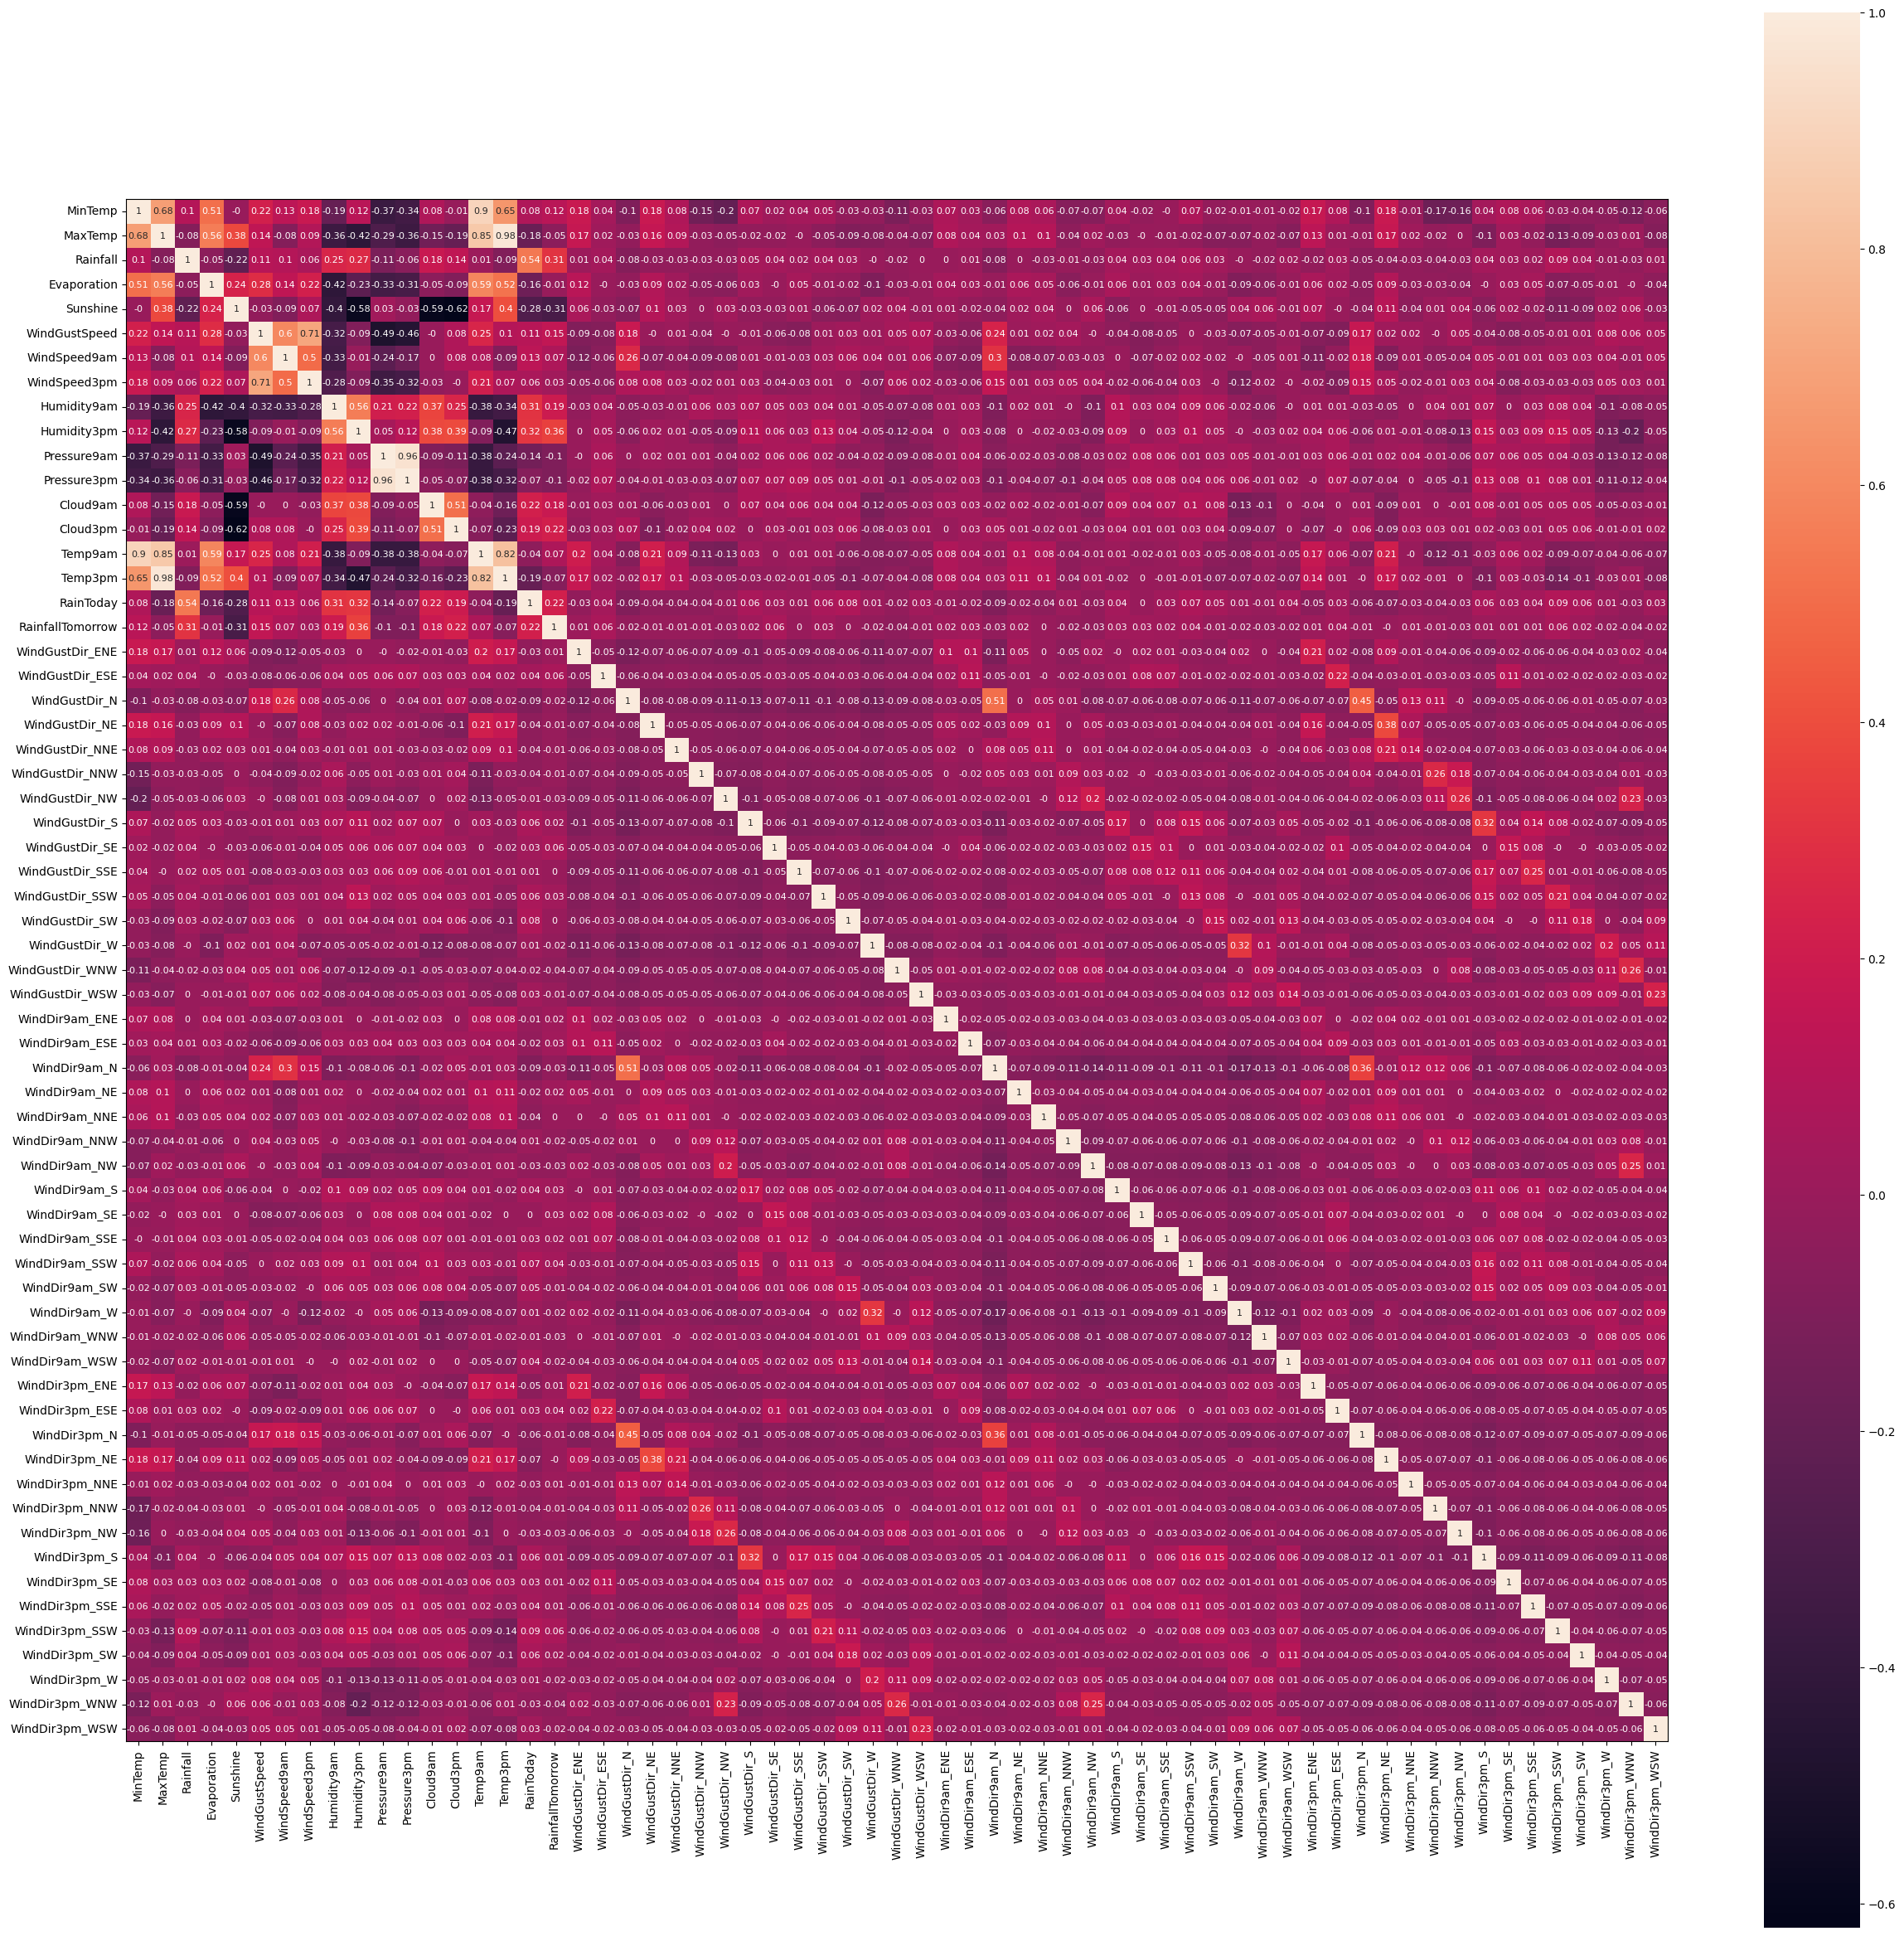

In [69]:
plt.figure(figsize=(30, 30))

heatmap = sns.heatmap(
    df_regre.corr().round(2),
    annot=True,
    square=True,
    annot_kws={'size': 8},  
)

for _, spine in heatmap.spines.items():
    spine.set_visible(True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.show()


Aca en la matriz de correlacion  podemos que variables tiene mas correlacion con la variable que queremos predecir, podemos ver si su correlacon es positiva o negativa, si la correllacion es alta o baja, pero no vamos a usar el criterio de eliminar variables por su correlacion con la variable a predecir. 

### SCATTER PLOT entre variable a predecir  RainfallTomorrow y el resto de las variables cuantitativas

Error in callback <function _draw_all_if_interactive at 0x7ff41ee45a20> (for post_execute):


KeyboardInterrupt: 

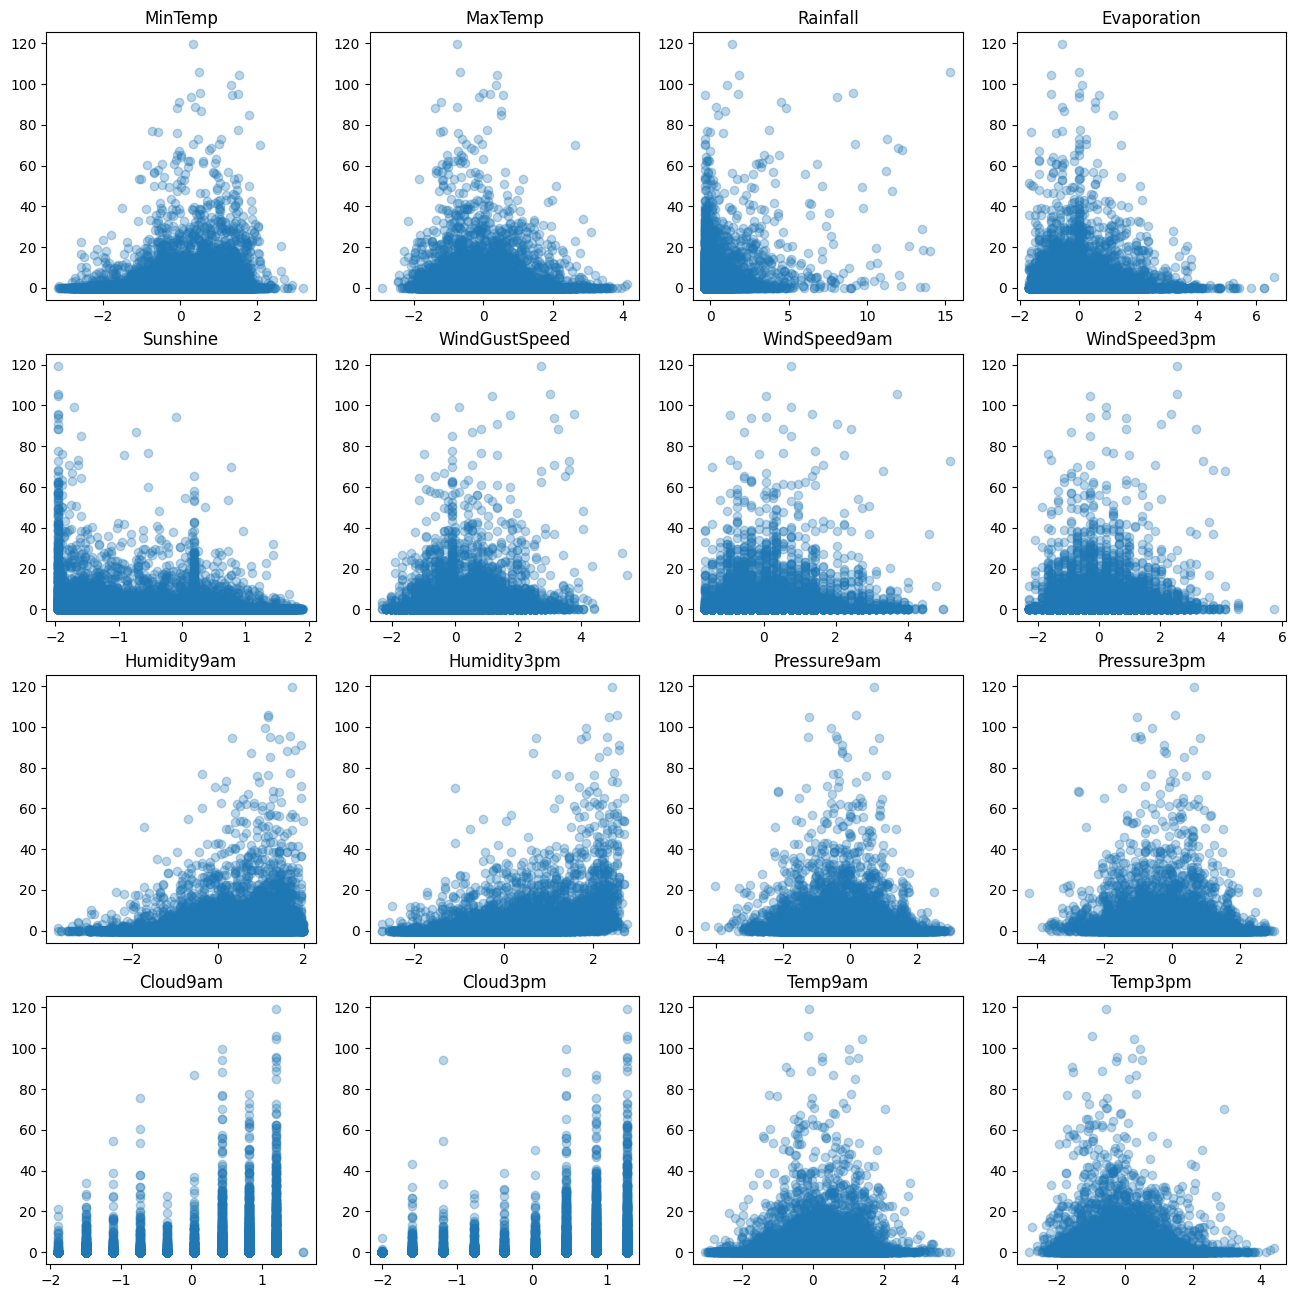

In [70]:
plt.figure(figsize=(16, 16))

for idx, col in enumerate(df_regre.columns[:16], start=1):  
    plt.subplot(4, 4, idx)
    plt.scatter(data=df_regre, x=col, y='RainfallTomorrow', alpha=.3)
    plt.title(col)


Vemos que no hay fuertes asocianes lieneales positivas, ni negativas.  

### VOLVEMOS A SEPARAR LOS DATFRAME

In [ ]:
x_train_regre = df_regre.iloc[:, :-1]  
y_train_regre = df_regre.iloc[:, -1]  
x_train_regre = pd.DataFrame(x_train_regre)
y_train_regre = pd.DataFrame(y_train_regre)

x_train_clasi = df_clasi.iloc[:, :-1]  
y_train_clasi = df_clasi.iloc[:, -1]  


In [ ]:
x_train_regre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12028 entries, 10395 to 11358
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           12028 non-null  float64
 1   MaxTemp           12028 non-null  float64
 2   Rainfall          12028 non-null  float64
 3   Evaporation       12028 non-null  float64
 4   Sunshine          12028 non-null  float64
 5   WindGustSpeed     12028 non-null  float64
 6   WindSpeed9am      12028 non-null  float64
 7   WindSpeed3pm      12028 non-null  float64
 8   Humidity9am       12028 non-null  float64
 9   Humidity3pm       12028 non-null  float64
 10  Pressure9am       12028 non-null  float64
 11  Pressure3pm       12028 non-null  float64
 12  Cloud9am          12028 non-null  float64
 13  Cloud3pm          12028 non-null  float64
 14  Temp9am           12028 non-null  float64
 15  Temp3pm           12028 non-null  float64
 16  RainToday         12028 non-null  float64

In [ ]:
y_train_regre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12028 entries, 10395 to 11358
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   WindDir3pm_WSW  12028 non-null  uint8
dtypes: uint8(1)
memory usage: 105.7 KB


In [ ]:
y_train_regre.dropna(inplace=True)

In [ ]:
y_train_regre.shape

(12028, 1)

In [ ]:
x_train_regre

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW
10395,-0.699344,-1.632675,0.217068,-1.487897,-0.284314,-0.363241,0.056092,0.657248,0.521464,0.157821,...,False,False,False,True,False,False,False,False,False,False
13735,0.812238,0.211731,-0.306551,0.809873,0.968467,-0.643870,-0.338178,-0.293048,-1.080586,-0.405798,...,False,False,False,False,False,True,False,False,False,False
7419,-0.240774,-0.414049,-0.306551,-0.791603,-1.175181,0.127862,-0.535314,-0.187460,0.713710,0.326906,...,False,False,False,False,False,False,False,False,False,False
310,1.423664,0.705769,-0.306551,0.949131,-0.590550,-0.082611,-0.535314,-0.187460,0.777792,1.510506,...,False,False,False,False,True,False,False,False,False,False
14388,0.965094,2.896002,-0.306551,1.715055,1.413900,1.601169,3.308822,1.396367,-3.195292,-2.434826,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14973,-0.070934,-1.122170,-0.306551,-1.139750,-1.843331,-0.363241,0.548930,0.234894,0.585546,1.792315,...,False,False,False,False,False,False,False,True,False,False
4725,0.931126,-0.216434,-0.306551,1.715055,0.801430,1.460854,1.436038,1.185190,-0.055274,1.003249,...,False,False,False,True,False,False,False,False,False,False
15678,-0.359663,-1.155106,-0.149465,-0.861233,-1.731973,-0.784185,-0.535314,-1.348933,0.713710,1.172335,...,False,True,False,False,False,False,False,False,False,False
7211,-0.563471,-0.018819,-0.306551,0.113579,0.940628,-0.082611,-1.619557,-1.665698,1.226366,-0.011265,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
x_train_regre['Rainfall'].mean()

-2.9537027592288835e-18

In [ ]:
x_test_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3008 entries, 4616 to 11848
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3008 non-null   object 
 1   Location       3008 non-null   object 
 2   MinTemp        3008 non-null   float64
 3   MaxTemp        3008 non-null   float64
 4   Rainfall       3008 non-null   float64
 5   Evaporation    2672 non-null   float64
 6   Sunshine       2632 non-null   float64
 7   WindGustDir    2700 non-null   object 
 8   WindGustSpeed  2700 non-null   float64
 9   WindDir9am     3008 non-null   object 
 10  WindDir3pm     3008 non-null   object 
 11  WindSpeed9am   2962 non-null   float64
 12  WindSpeed3pm   2967 non-null   float64
 13  Humidity9am    2989 non-null   float64
 14  Humidity3pm    3005 non-null   float64
 15  Pressure9am    2969 non-null   float64
 16  Pressure3pm    2969 non-null   float64
 17  Cloud9am       2654 non-null   float64
 18  Cloud3pm 

# Regresión Lineal

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg = LinearRegression()

reg.fit(x_train_regre, y_train_regre)

LinearRegression()

# Regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistica = LogisticRegression()

# logistica.fit(x_train_clas, y_train_clas)

# Redes neuronales

# Conclusiones finales